In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import os
import torchattacks # We import this directly

print("Libraries imported.")

Libraries imported.


In [2]:
# Cell 2: Define Constants and Paths
# Paths (relative to the 'notebooks' folder)
DATA_DIR = "../data/processed"
MODEL_DIR = "../models"
TEST_FILE = os.path.join(DATA_DIR, "test.pt")
BASELINE_MODEL_PATH = os.path.join(MODEL_DIR, "cnn_classifier.pth")

# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
N_IMAGES = 6 # Number of images to show

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Cell 3: Define Helper Functions (from src/model_zoo and src/visualize)

# Copied from src/model_zoo.py
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x); x = F.relu(x); x = self.pool(x)
        x = self.conv2(x); x = F.relu(x); x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7); x = self.dropout(x)
        x = self.fc1(x); x = F.relu(x); x = self.fc2(x)
        return x

# Copied from src/visualize.py
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    mean = torch.tensor(mean).to(tensor.device)
    std = torch.tensor(std).to(tensor.device)
    if tensor.dim() == 4:
        mean = mean.view(1, -1, 1, 1)
        std = std.view(1, -1, 1, 1)
    elif tensor.dim() == 3:
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return torch.clamp(tensor, 0, 1)

print("Helper functions defined (BaseCNN, unnormalize).")

Helper functions defined (BaseCNN, unnormalize).


In [4]:
# Cell 4: Load Model and Data
try:
    # Load the trained classifier
    classifier = BaseCNN().to(DEVICE)
    classifier.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=DEVICE))
    classifier.eval()
    print(f"Model loaded from {BASELINE_MODEL_PATH}")

    # Load one batch of test data
    test_images, test_labels = torch.load(TEST_FILE)
    test_ds = TensorDataset(test_images, test_labels)
    test_loader = DataLoader(test_ds, batch_size=N_IMAGES, shuffle=True)
    clean_images, true_labels = next(iter(test_loader))
    clean_images, true_labels = clean_images.to(DEVICE), true_labels.to(DEVICE)
    print("Data batch loaded.")
    
except FileNotFoundError as e:
    print(f"---!!! ERROR: File not found! !!!---")
    print(e)
    print("Please run Notebook 2 to train and save the model, or run your datautils script.")

Model loaded from ../models\cnn_classifier.pth
Data batch loaded.


In [5]:
# Cell 5: Generate Adversarial Examples
print("Generating FGSM attacks (eps=0.3)...")
# We initialize the attack directly, no wrapper needed
fgsm_attack = torchattacks.FGSM(classifier, eps=0.3)
fgsm_attack.set_normalization_used(mean=MNIST_MEAN, std=MNIST_STD)
adv_images = fgsm_attack(clean_images, true_labels)

Generating FGSM attacks (eps=0.3)...


In [6]:
# Cell 6: Get Predictions for Both
classifier.eval()
with torch.no_grad():
    clean_outputs = classifier(clean_images)
    _, clean_preds = torch.max(clean_outputs.data, 1)
    
    adv_outputs = classifier(adv_images)
    _, adv_preds = torch.max(adv_outputs.data, 1)

print(f"True Labels:        {true_labels.cpu().numpy()}")
print(f"Clean Preds:        {clean_preds.cpu().numpy()}")
print(f"Adversarial Preds: {adv_preds.cpu().numpy()}")

True Labels:        [8 3 1 7 3 0]
Clean Preds:        [8 3 1 7 3 0]
Adversarial Preds: [2 3 3 9 3 8]


Plotting comparison...


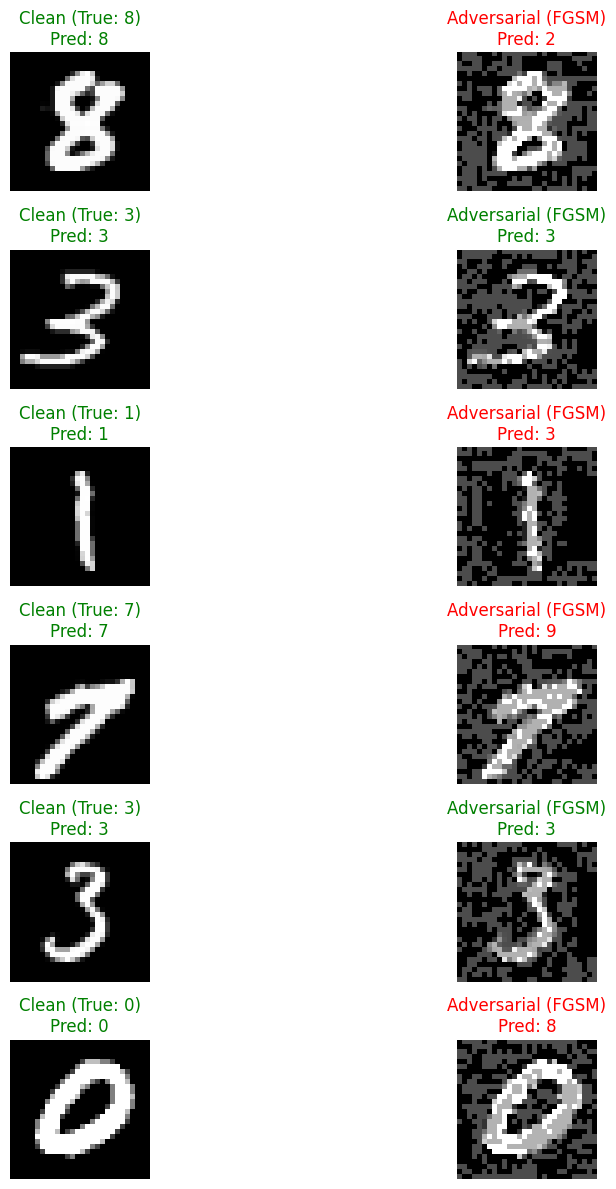

In [7]:
# Cell 7: Plot Comparison
print("Plotting comparison...")

plot_clean = unnormalize(clean_images.cpu(), MNIST_MEAN, MNIST_STD)
plot_adv = unnormalize(adv_images.cpu(), MNIST_MEAN, MNIST_STD)

plt.figure(figsize=(12, N_IMAGES * 2))
for i in range(N_IMAGES):
    ax = plt.subplot(N_IMAGES, 2, 2*i + 1)
    plt.imshow(plot_clean[i].squeeze(), cmap="gray")
    color = "green" if clean_preds[i] == true_labels[i] else "red"
    ax.set_title(f"Clean (True: {true_labels[i].item()})\nPred: {clean_preds[i].item()}", color=color)
    ax.axis("off")
    
    ax = plt.subplot(N_IMAGES, 2, 2*i + 2)
    plt.imshow(plot_adv[i].squeeze(), cmap="gray")
    color = "red" if adv_preds[i] != true_labels[i] else "green"
    ax.set_title(f"Adversarial (FGSM)\nPred: {adv_preds[i].item()}", color=color)
    ax.axis("off")
    
plt.tight_layout()
plt.show()